### SwiGlu(前馈网络)

#### 1. 为什么需要FFN？  
- 交流阶段：每个词把全局和自己最相关的特征进行抓取，存在自己的向量里  
- 计算阶段：每个词回到自己的位置上，利用FFN对刚抓取到的素材进行深度消化。通过高维投影和非线性变换，把零散的上下文信号合并成更高阶的语义概念

#### 2. 什么是SwiGlu? 
SwiGLU（Swish-GLU）是一种新的激活函数组合，它结合了Swish和GLU（门控线性单元）的优点。SwiGLU的计算公式为：

$$SwiGLU(x) = x * σ(αx) + (1 - x) * γx$$
其中，α和γ是两个超参数，用于控制SwiGLU的激活函数的形状
- Swish：激活函数为$σ(x)=x/(1+e^{-x})$。Swish在0附近有一个平滑的小坑，可以在求导时更平滑，有助于模型学习微小细节 
- GLU：门控线性单元，将输入的信号分为两个部分，分别进行线性变换和激活，然后进行加和


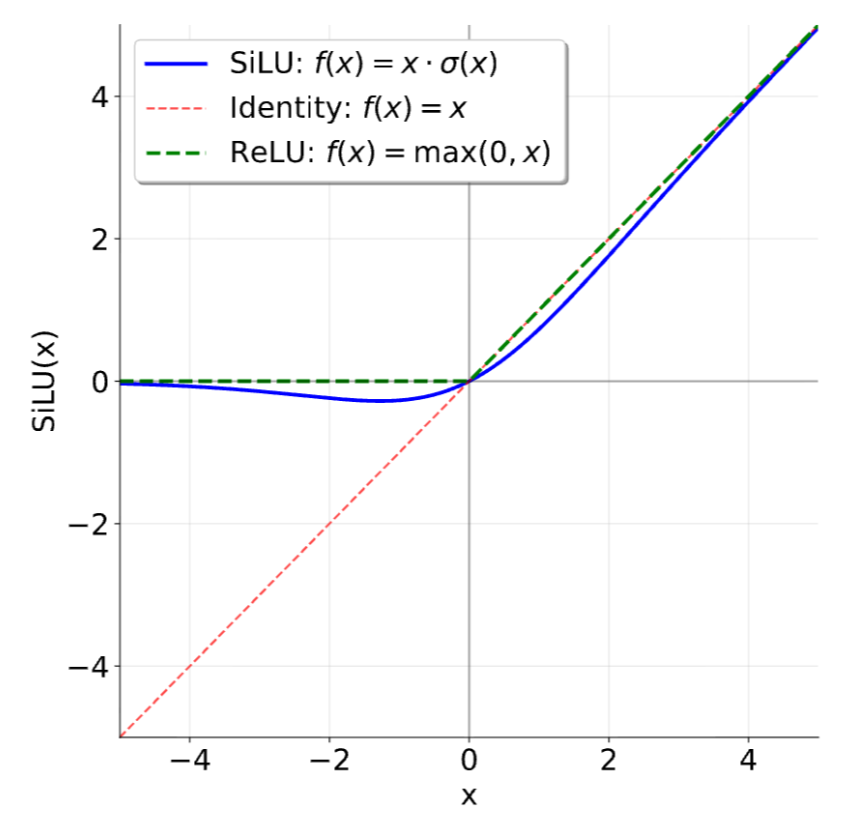

#### 3.关键的2/3法则  
- 传统FFN：使用2个矩阵。总参数量为：$8\times d_{model}^2$  
-  SwiGlu:使用了三个矩阵（W1,W3升维度，W2降维） 
-  如何对齐参数量：为了让总参数量与传统FFN一致，不使用4倍升维，而是将中间维度$d_{ff}$设置为$d_model$的8/3倍  
-  硬件对齐；为了优化GPU计算效率，$d_{ff}$通常向上取整为64倍数


In [2]:
import torch 
import matplotlib.pyplot as plt
import numpy as np 
#中文和负号显示  
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
torch.manual_seed(42)  # 固定随机种子，结果可复现
np.random.seed(42)

In [3]:
def swish(x: torch.Tensor, beta:float=1.0) -> torch.Tensor:
  """
  swish激活函数
  """
  # x * sigmoid(beta * x)
  return x * torch.sigmoid(beta * x)   

def swiglu(x: torch.Tensor) -> torch.Tensor:
  """
  swiglu激活函数
  param x: 输入张量，最后一个维度为偶数
  return: 激活后的张量，形状与输入一致
  """
  x1, x2 = torch.chunk(x, 2, dim=-1)
  return swish(x1) * x2



In [4]:
 # 一维连续数据：用于绘制函数/梯度曲线（范围[-5,5]，步长0.1）
x_1d = torch.linspace(-5, 5, steps=1000, dtype=torch.float32, requires_grad=True)
# 扩展维度：适配torch.chunk（最后一维需偶数，扩展为[1000,2]，切分为[1000,1]和[1000,1]）
x_1d_expand = torch.stack([x_1d, x_1d], dim=-1)  # 形状 [1000, 2]

# 批量随机张量：模拟模型中间层输出（形状[32, 128]，符合大模型维度习惯）
x_batch = torch.randn(32, 128, dtype=torch.float32)  # 批量32，特征维度128（偶数）


# 一维数据前向计算
y_swiglu = swiglu(x_1d_expand)
# 计算梯度：对输入x_1d求导（模拟反向传播）
y_swiglu.sum().backward()
swiglu_grad = x_1d.grad  # 提取SwiGLU的梯度值

# 批量数据前向计算
y_batch_swiglu = swiglu(x_batch)

C:\Users\23017\AppData\Local\Temp\ipykernel_24208\3308206989.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot([data_input, data_swiglu], labels=['输入张量', 'SwiGLU输出'], patch_artist=True,


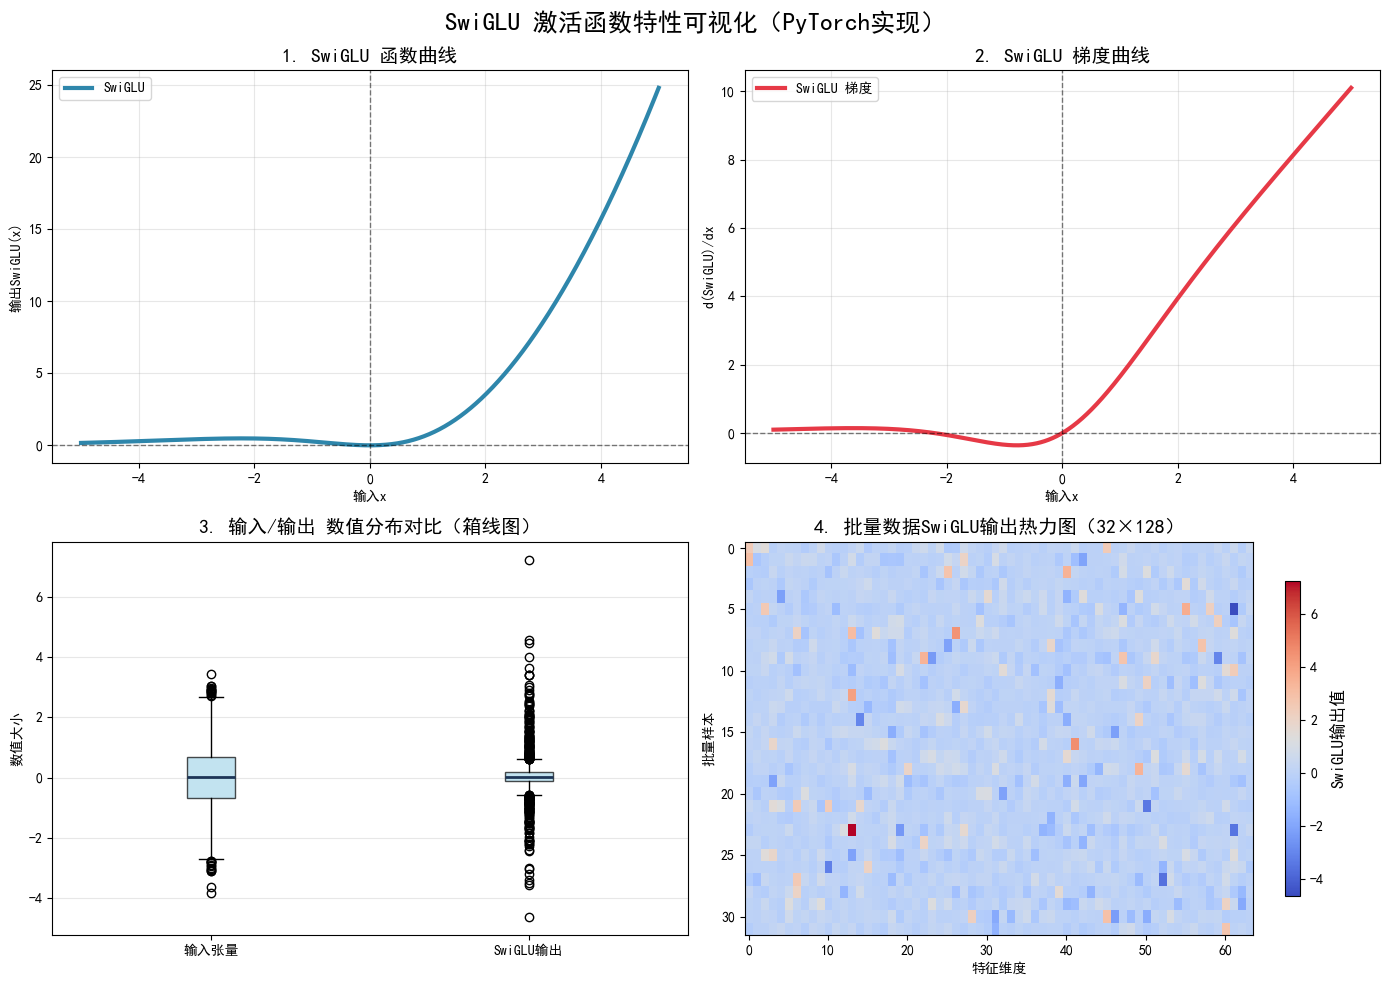

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('SwiGLU 激活函数特性可视化（PyTorch实现）', fontsize=18, fontweight='bold', y=0.98)

# SwiGLU 函数曲线（[-5,5]）
ax1 = axes[0, 0]
ax1.plot(x_1d.detach().numpy(), y_swiglu.squeeze().detach().numpy(), color='#2E86AB', linewidth=3, label='SwiGLU')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_title('1. SwiGLU 函数曲线', fontsize=14, fontweight='bold')
ax1.set_xlabel('输入x')
ax1.set_ylabel('输出SwiGLU(x)')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# SwiGLU 梯度曲线（反映优化特性）
ax2 = axes[0, 1]
ax2.plot(x_1d.detach().numpy(), swiglu_grad.detach().numpy(), color='#E63946', linewidth=3, label='SwiGLU 梯度')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax2.set_title('2. SwiGLU 梯度曲线', fontsize=14, fontweight='bold')
ax2.set_xlabel('输入x')
ax2.set_ylabel('d(SwiGLU)/dx')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# 输入张量 VS SwiGLU输出 数值分布（箱线图，展示分布变化）
ax3 = axes[1, 0]
# 整理数据：展平为一维，便于箱线图对比
data_input = x_batch.detach().numpy().flatten()
data_swiglu = y_batch_swiglu.detach().numpy().flatten()
ax3.boxplot([data_input, data_swiglu], labels=['输入张量', 'SwiGLU输出'], patch_artist=True,
            boxprops={'facecolor': '#A8D8EA', 'alpha':0.7}, medianprops={'color':'#1D3557', 'linewidth':2})
ax3.set_title('3. 输入/输出 数值分布对比（箱线图）', fontsize=14, fontweight='bold')
ax3.set_ylabel('数值大小')
ax3.grid(True, alpha=0.3, axis='y')

# SwiGLU 输出张量 热力图（展示批量数据的激活效果）
ax4 = axes[1, 1]
im = ax4.imshow(y_batch_swiglu.detach().numpy(), cmap='coolwarm', aspect='auto')
cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
cbar.set_label('SwiGLU输出值', fontsize=12)
ax4.set_title('4. 批量数据SwiGLU输出热力图（32×128）', fontsize=14, fontweight='bold')
ax4.set_xlabel('特征维度')
ax4.set_ylabel('批量样本')

# 调整子图间距，避免重叠
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

- 函数曲线：SwiGLU 是平滑的非线性函数，无 ReLU 的硬阈值，x<0 时非全零，保留负向信息，提升模型表达能力；
- 梯度曲线：梯度全程平滑无突变，无梯度消失 / 爆炸问题（x∈[-5,5] 时梯度在 0~1 之间），适合大模型深度训练；
- 箱线图分布：SwiGLU 会对输入的正态分布做轻微压缩，输出均值更接近 0，方差更小，缓解模型训练中的数值不稳定；
- 热力图：直观展示批量样本 × 特征维度的激活效果，不同位置的输出值有明显差异，体现特征选择能力（门控机制作用）

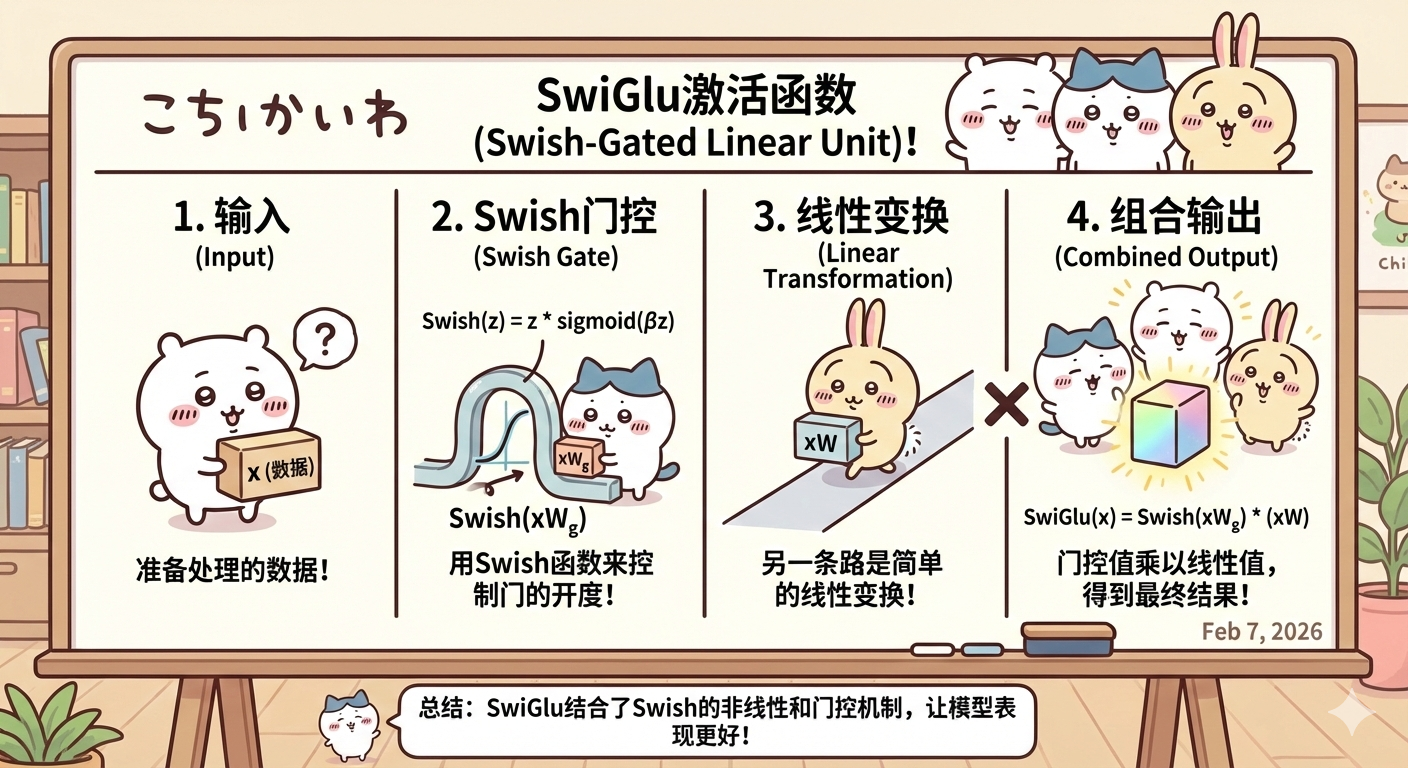